<a href="https://colab.research.google.com/github/neuromorph/TweetEval-Sentiment-HF/blob/main/TweetEval_Sentiment_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import transformers, datasets

In [3]:
from datasets import load_dataset

In [4]:
senti_ds = load_dataset("tweet_eval", "sentiment")
senti_ds

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = senti_ds["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 45615
})

In [6]:
train_ds[0], len(train_ds)

({'label': 2,
  'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"'},
 45615)

In [7]:
train_df = pd.DataFrame(train_ds)
# train_df = senti_df["train"][:]
train_df.head()

,text,label
0,"""QT @user In the original draft of the 7th boo...",2
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,2


In [8]:
def label_int2str(row):
    return train_ds.features["label"].int2str(row)

train_df["label_name"] = train_df["label"].apply(label_int2str)
train_df.head()

,text,label,label_name
0,"""QT @user In the original draft of the 7th boo...",2,positive
1,"""Ben Smith / Smith (concussion) remains out of...",1,neutral
2,Sorry bout the stream last night I crashed out...,1,neutral
3,Chase Headley's RBI double in the 8th inning o...,1,neutral
4,@user Alciato: Bee will invest 150 million in ...,2,positive


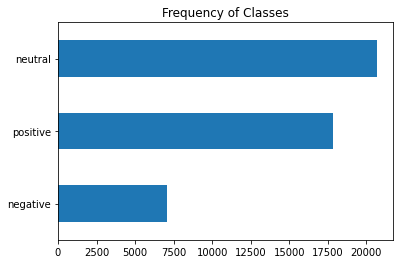

In [9]:

train_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


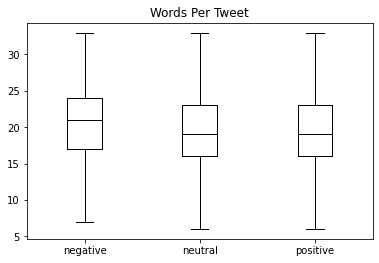

In [ ]:
train_df["Words Per Tweet"] = train_df["text"].str.split().apply(len)
train_df.boxplot("Words Per Tweet", by="label_name", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [10]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [11]:

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
    
tokenize(train_ds[0])

{'input_ids': [101, 1000, 1053, 2102, 1030, 5310, 1999, 1996, 2434, 4433, 1997, 1996, 5504, 2338, 1010, 2128, 7606, 11320, 8091, 5175, 1996, 2645, 1997, 27589, 18367, 2015, 1012, 1001, 3407, 17706, 2705, 10259, 28578, 2271, 7630, 8091, 1000, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [12]:
train_ds[0]

{'label': 2,
 'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"'}

In [13]:
senti_tok = senti_ds.map(tokenize, batched=True, batch_size=None)
print(senti_tok["train"].column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask']


In [18]:
senti_tok["validation"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})

In [30]:
import torch
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))
device

device(type='cpu')

In [2]:
# import torch
torch.cuda.is_available()

True

In [15]:
import sklearn
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [16]:

from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [29]:
from transformers import Trainer, TrainingArguments

batch_size = 128
logging_steps = len(senti_tok["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-tweet_eval-sentiment"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  fp16=True,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1243, 8))



ValueError: ignored

In [ ]:
# from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=senti_tok["train"],
                  eval_dataset=senti_tok["validation"],
                  tokenizer=tokenizer)
trainer.train();

In [ ]:

preds_output = trainer.predict(senti_tok["validation"])
preds_output.metrics

In [20]:
import os
try:
    device_name = os.environ['COLAB_TPU_ADDR']
    TPU_ADDRESS = 'grpc://' + device_name
    print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
    print('TPU not found')

Found TPU at: grpc://10.19.119.66:8470


In [21]:
pip install cloud-tpu-profiler

In [ ]:
!capture_tpu_profile --service_addr 10.19.119.66:8470 --monitoring_level 2

In [26]:
import subprocess
subprocess.Popen(["capture_tpu_profile", "--service_addr={}".format(os.environ['COLAB_TPU_ADDR'])])

In [3]:
!pip install GPUtil
from GPUtil import showUtilization as gpu_usage
gpu_usage()

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=1b09fb1eb6d4404a9766db0aeca973b58b336b9ea66990bf23c404dd8f626ff6
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
